<a href="https://colab.research.google.com/github/Ayikanying-ux/regresion-predict_fuel_efficiency/blob/main/Basic_regression_Predict_fuel_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In a regression problem, the aim to is to predict the output of a continuous value, like a price or probability. Contrast this with a classification problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing with fruit is in the picture)

This tutorial uses the classic Auto MPG dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

In [2]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [3]:
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
import seaborn as sns

# Make Numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.15.0


The Auto MPG dataset
The dataset is available from the UCI Machine Learning Repository.

Get the data

First download and import the dataset using pandas:

In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [6]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the data
The dataset contains a few unknown values:

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop those rows to keep this initial tutorial simple

The "Origin" column is categorical, not numeric. So the next step is to one-hot encode the values in the column with pd.get_dummies.

In [8]:
dataset = dataset.dropna()

In [9]:
dataset['Origin'] = dataset['Origin'].map(({1:"USA", 2:"Europe", 3:"Japan"}))

In [10]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


# Split the data into training and test sets
Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your model

In [15]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Inspect the data
Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters.The other rows indicate they are functions of each other

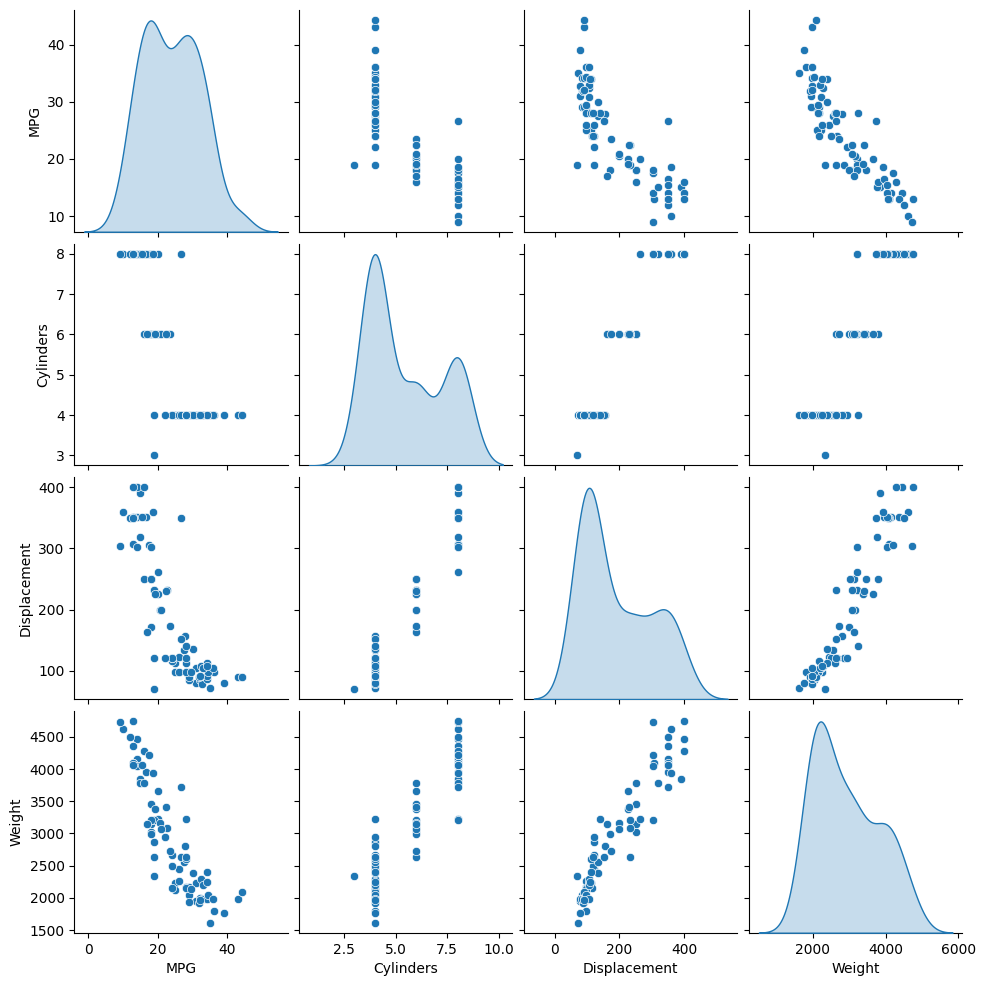

In [12]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [13]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,78.0,23.991026,8.133563,9.0,18.00,24.00,29.875,44.3
Cylinders,78.0,5.448718,1.740633,3.0,4.00,4.00,8.000,8.0
Displacement,78.0,190.762821,106.494733,70.0,98.00,138.00,292.000,400.0
Horsepower,78.0,102.858974,40.255265,48.0,74.25,90.00,121.750,230.0
Weight,78.0,2926.589744,874.900416,1613.0,2159.50,2692.50,3706.500,4746.0
Acceleration,78.0,15.469231,2.649298,8.5,13.70,15.25,17.000,22.2
Model Year,78.0,76.307692,3.721847,70.0,73.00,76.00,79.750,82.0


## Split features from labels
Separate the target value-the"label"-from the features. This label is the value that you will train the model to predict

In [16]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization
In the table of statistics it's easy to see how different the ranges of each feature are:

In [17]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
